In [82]:
# Imports
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from web3 import Web3
from datetime import datetime, timedelta, timezone
import time

# Map token names to contract addresses
token_address_map = {
    'rETH': '0xae78736Cd615f374D3085123A210448E74Fc6393'
    # fill with rest
}

# Map market name to "Pool" contract address and abi filepath
contract_address_abi_map = {
    'AAVE': ('0x7B4EB56E7CD4b454BA8ff71E4518426369a138a3', './AAVE_PoolDataProvider_ABI.json'),
    'COMPOUND': ('0xA17581A9E3356d9A858b789D68B4d866e593aE94', './Compound_ABI.json')
    # fill with rest
}

# Connect to ETH blockchain with infura API key
w3 = Web3(Web3.HTTPProvider('https://mainnet.infura.io/v3/5f0c4998d7544ee1bb3f0dc297a6821c'))

In [83]:
# Align to nearest previous interval
def align_to_interval(dt, interval_hours):
    aligned_hour = (dt.hour // interval_hours) * interval_hours
    return dt.replace(hour=aligned_hour, minute=0, second=0, microsecond=0, tzinfo=timezone.utc)

# Find block number closest to timestamp with binary search
def get_block_number_by_timestamp(target_timestamp):
    low, high = 0, w3.eth.block_number
    while low < high:
        mid = (low + high) // 2
        mid_block_timestamp = w3.eth.get_block(mid).timestamp
        if mid_block_timestamp < target_timestamp:
            low = mid+1
        else:
            high = mid
    return low

# Interpolate block number of target time between start and end blocks to minimize api calls
def interpolate_block_numbers(start_block, end_block, start_time, end_time, target_time):
    block_interval = end_block - start_block
    time_interval = (end_time - start_time).total_seconds()
    time_offset = (target_time - start_time).total_seconds()
    
    # Find interpolated block number for target time
    interpolated_block = start_block + (block_interval * (time_offset / time_interval))
    return int(interpolated_block)

# Get block numbers for specified timeframe and timestep
def get_blocks_for_timeframe(interval_hours, days_back):
    block_numbers = {}
    end_datetime = datetime.utcnow()
    start_datetime = end_datetime - timedelta(days = days_back)
    
    # Align start and end times to nearest previous interval
    start_datetime = align_to_interval(start_datetime, interval_hours)
    end_datetime = align_to_interval(end_datetime, interval_hours)
    
    # Get block numbers for start and end (2 api calls)
    start_block = get_block_number_by_timestamp(int(start_datetime.timestamp()))
    end_block = get_block_number_by_timestamp(int(end_datetime.timestamp()))
    
    # Loop from start datetime to end datetime and store block numbers for intervals
    current_datetime = start_datetime
    while current_datetime <= end_datetime:
        if current_datetime == start_datetime:
            block_number = start_block
        elif current_datetime == end_datetime:
            block_number = end_block
        else:
            # Find interpolated block number
            block_number = interpolate_block_numbers(start_block,
                                                     end_block,
                                                     start_datetime,
                                                     end_datetime,
                                                     current_datetime)
        
        formatted_key = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
        block_numbers[current_datetime.timestamp()] = block_number        
        current_datetime += timedelta(hours=interval_hours)
        
    return block_numbers

In [87]:
# Reserve data object
class ReserveData:
    def __init__(self, data):
        self.unbacked_aTokens = data[0]
        self.tokens_accrued_to_treasury = data[1]
        self.total_aToken_supply = data[2]
        self.total_stable_debt = data[3]
        self.total_variable_debt = data[4]
        self.liquidity_rate = data[5]
        self.variable_borrow_rate = data[6]
        self.stable_borrow_rate = data[7]
        self.average_stable_borrow_rate = data[8]
        self.liquidity_index = data[9]
        self.variable_borrow_index = data[10]
        self.last_update_timestamp = data[11]

    def __repr__(self):
        return (f"ReserveData(\n\tunbacked_aTokens = {self.unbacked_aTokens}, "
                f"\n\ttokens_accrued_to_treasury = {self.tokens_accrued_to_treasury}, "
                f"\n\ttotal_aToken_supply = {self.total_aToken_supply}, "
                f"\n\ttotal_stable_debt = {self.total_stable_debt}, "
                f"\n\ttotal_variable_debt = {self.total_variable_debt}, "
                f"\n\tliquidity_rate = {self.liquidity_rate}, "
                f"\n\tvariable_borrow_rate = {self.variable_borrow_rate}, "
                f"\n\tstable_borrow_rate = {self.stable_borrow_rate}, "
                f"\n\taverage_stable_borrow_rate = {self.average_stable_borrow_rate}, "
                f"\n\tliquidity_index = {self.liquidity_index}, "
                f"\n\tvariable_borrow_index = {self.variable_borrow_index}, "
                f"\n\tlast_update_timestamp = {self.last_update_timestamp}\n)")

# Historical borrow function
def historical_borrow_and_supply(market, timeframe = 365, interval = 6, token = 'rETH'):
    """
    Fetches historical data for a specified token from the specified protocol over a given timeframe and at specified intervals.
    
    Parameters:
    - market (str): The lending and borrowing market from which to fetch data. Defaults to 'AAVE'.
    - timeframe (int): The number of days back from the current date to fetch data. Defaults to 365 days.
    - interval (int): The interval, in hours, at which to fetch data. Defaults to 1 hour.
    - token (str): The name of the token to fetch data for. Defaults to 'rETH'.
    
    Returns:
    pandas.DataFrame: A DataFrame where each row corresponds to a time point within the timeframe and includes the following columns:
        - 'Timestamp': The timestamp in 'YYYY-MM-DD HH:MM:SS' format.
        - 'Market': The lending and borrowing market from which the data was fetched.
        - 'Data Type': Label for the data type fetched.
        - 'Value': Numeric value of the data fetched.
    
    """
    # Make sure the requested market is supported
    if market in contract_address_abi_map.keys():
        # Lookup token address, contract address, and abi filepath
        token_address = token_address_map[token]
        contract_address, abi_filepath = contract_address_abi_map[market]


        # Web3 setup
        with open(abi_filepath) as f:
            abi = json.load(f)

        smart_contract = w3.eth.contract(address=contract_address, abi=abi)

        # Get blocks for specified timeframe and interval
        blocks = get_blocks_for_timeframe(interval, timeframe)

        # Get borrow and supply amounts
        data = {
            'Timestamp': [],
            'Market': [],
            'Data Type': [],
            'Value': [],
        }
        
        if market == 'AAVE':
            for timestamp, block_number in blocks.items():
                # Sleep to not get API limited
                time.sleep(0.1)
                
                reserve_data_result = smart_contract.functions.getReserveData(token_address).call(block_identifier = block_number)
                reserve_data = ReserveData(reserve_data_result)

                # Pull out borrowed and supplied totals
                supplied_total = (reserve_data.total_aToken_supply) / 10**18
                borrowed_total = (reserve_data.total_stable_debt + reserve_data.total_variable_debt) / 10**18

                # Store borrowed rETH
                data['Timestamp'].append(timestamp)
                data['Market'].append(market)
                data['Data Type'].append('Supplied rETH')
                data['Value'].append(supplied_total)
                
                # Store supplied rETH
                data['Timestamp'].append(timestamp)
                data['Market'].append(market)
                data['Data Type'].append('Borrowed rETH')
                data['Value'].append(borrowed_total)
                
                
                # Store supplied rETH
        elif market == 'COMPOUND':
            for timestamp, block_number in blocks.items():
                # Sleep to not get API limited
                time.sleep(0.1)
                
                # Pull out supplied totals
                reserve_data_result = smart_contract.functions.totalsCollateral(token_address).call(block_identifier = block_number)
                supplied_total = (reserve_data_result[0]) / 10**18
                
                # Pull out borrow total OF MARKET -- NOT rETH
                borrowed_total = smart_contract.functions.totalBorrow().call(block_identifier = block_number) / 10**18
                
                # Store supplied rETH
                data['Timestamp'].append(timestamp)
                data['Market'].append(market)
                data['Data Type'].append('Supplied rETH')
                data['Value'].append(supplied_total)
                
                # Store supplied rETH
                data['Timestamp'].append(timestamp)
                data['Market'].append(market)
                data['Data Type'].append('Borrowed ETH')
                data['Value'].append(borrowed_total)
        else:
            print("FUTURE MARKETS HERE")
            return

        return pd.DataFrame(data)

In [102]:
global_all_markets = ['AAVE', 'COMPOUND']

def scrape_historic_all(timeframe = 365):
    """
    Organizes historical data for specified timeframe for all markets into a single DataFrame.
    Also, appends cumulative borrow and supplied rETH amounts to final DataFrame

    Returns:
    pandas.DataFrame: A DataFrame which contains historic data for all markets, where columns are:
        - 'Timestamp': The timestamp in 'YYYY-MM-DD HH:MM:SS' format.
        - 'Market': The lending and borrowing market from which the data was fetched.
        - 'Data Type': Label for the data type fetched.
        - 'Value': Numeric value of the data fetched.
    """
    full_df = None
    
    for market in global_all_markets:
        # Get market's historic data
        historic_data = historical_borrow_and_supply(market, timeframe=timeframe)
        
        full_df = pd.concat([full_df, historic_data], ignore_index=True)
        
    # compute cumulative amounts of borrowed and supplied rETH
        # filter for 'Supplied rETH' or 'Borrowed rETH'
    filtered_df = full_df[full_df['Data Type'].isin(['Supplied rETH', 'Borrowed rETH'])]
    
        # Group by timestamp and sum value column
    cumulative_df = filtered_df.groupby(['Timestamp', 'Data Type'])['Value'].sum().reset_index()
    
        # Add market label to cumulative values
    cumulative_df['Market'] = 'All Markets'
    
        # concatenate cumulative totals to previous full df 
    full_df = pd.concat([full_df, cumulative_df], ignore_index=True)
    
    return full_df

historic_data = scrape_historic_all(timeframe = 365)

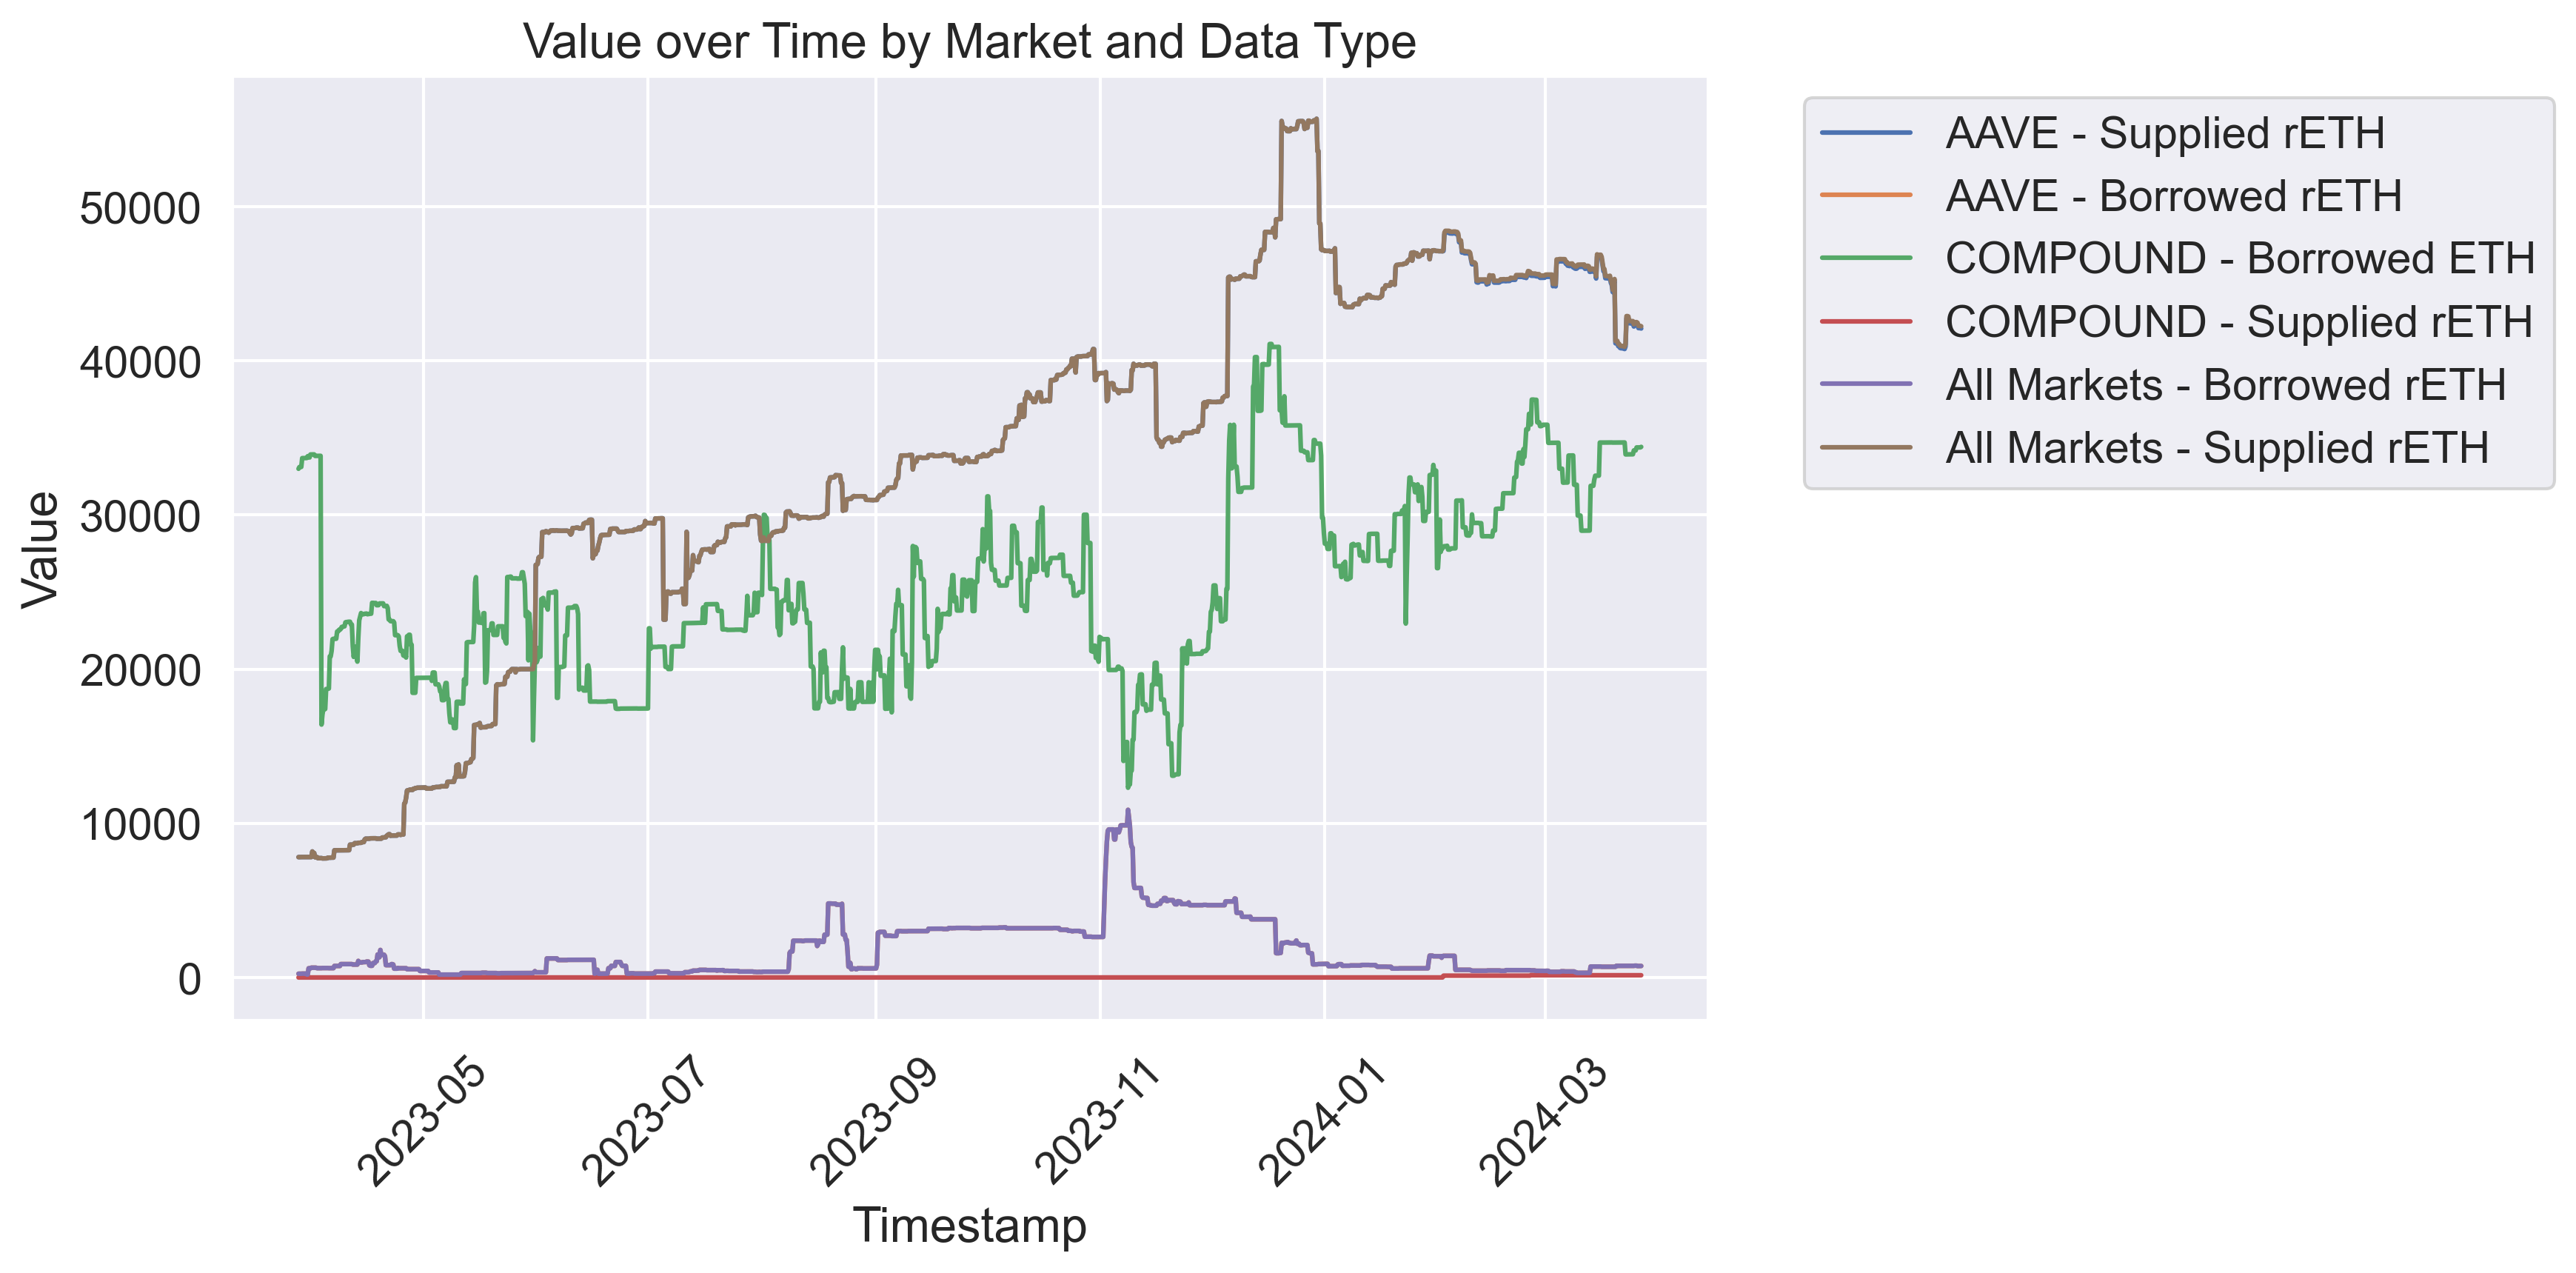

In [107]:
df = historic_data.copy()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s', utc=True)
df.sort_values('Timestamp', inplace=True)

# Create a new column that combines 'Market' and 'Data Type' for hue
df['Market & Type'] = df['Market'] + " - " + df['Data Type']

# Plot
sns.set_theme(style = 'darkgrid')
sns.set_context("notebook", font_scale=1.3)
plt.figure(figsize=(12, 6), dpi=300)
sns.lineplot(data=df, x='Timestamp', y='Value', hue='Market & Type', markers=True, dashes=False)

plt.title('Value over Time by Market and Data Type')
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.xlabel('Timestamp')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [108]:
historic_data

,Timestamp,Market,Data Type,Value
0,1.679962e+09,AAVE,Supplied rETH,7805.369316
1,1.679962e+09,AAVE,Borrowed rETH,244.152973
2,1.679983e+09,AAVE,Supplied rETH,7805.371005
3,1.679983e+09,AAVE,Borrowed rETH,244.153783
4,1.680005e+09,AAVE,Supplied rETH,7805.371701
...,...,...,...,...
8761,1.711454e+09,All Markets,Supplied rETH,42262.354191
8762,1.711476e+09,All Markets,Borrowed rETH,745.771416
8763,1.711476e+09,All Markets,Supplied rETH,42262.355397
8764,1.711498e+09,All Markets,Borrowed rETH,745.772839


In [104]:
historic_data[(historic_data['Market'] == 'All Markets') & (historic_data['Data Type'] == 'Borrowed rETH')]

,Timestamp,Market,Data Type,Value
5844,1.679962e+09,All Markets,Borrowed rETH,244.152973
5846,1.679983e+09,All Markets,Borrowed rETH,244.153783
5848,1.680005e+09,All Markets,Borrowed rETH,244.154602
5850,1.680026e+09,All Markets,Borrowed rETH,244.155419
5852,1.680048e+09,All Markets,Borrowed rETH,250.156239
...,...,...,...,...
8756,1.711411e+09,All Markets,Borrowed rETH,740.767216
8758,1.711433e+09,All Markets,Borrowed rETH,740.768593
8760,1.711454e+09,All Markets,Borrowed rETH,745.769997
8762,1.711476e+09,All Markets,Borrowed rETH,745.771416


In [105]:
historic_data[(historic_data['Market'] == 'All Markets') & (historic_data['Data Type'] == 'Borrowed rETH')]

,Timestamp,Market,Data Type,Value
5844,1.679962e+09,All Markets,Borrowed rETH,244.152973
5846,1.679983e+09,All Markets,Borrowed rETH,244.153783
5848,1.680005e+09,All Markets,Borrowed rETH,244.154602
5850,1.680026e+09,All Markets,Borrowed rETH,244.155419
5852,1.680048e+09,All Markets,Borrowed rETH,250.156239
...,...,...,...,...
8756,1.711411e+09,All Markets,Borrowed rETH,740.767216
8758,1.711433e+09,All Markets,Borrowed rETH,740.768593
8760,1.711454e+09,All Markets,Borrowed rETH,745.769997
8762,1.711476e+09,All Markets,Borrowed rETH,745.771416
